# 🎓 Session 4: Pretraining & Finetuning LLMs

**Workshop: Build a Large Language Model From Scratch**  
**Duration**: 3 hours (1:30 PM - 4:30 PM)  
**Day 2 - Final Session**

**Instructor Notes**: 📢 indicates what to say, 💡 indicates key points to emphasize

---

## 📋 Session Overview

| Time | Topic | Type |
|------|-------|------|
| 1:30 - 2:15 | Pretraining Fundamentals | Theory + Demo |
| 2:15 - 2:45 | Loading Pretrained Weights | Hands-on |
| 2:45 - 3:00 | Break | - |
| 3:00 - 4:00 | Finetuning for Classification | Hands-on |
| 4:00 - 4:30 | Workshop Wrap-up & Next Steps | Discussion |

---
# Part 1: Pretraining Fundamentals (45 min)
---

## 📢 Instructor Script

> "Welcome to our final session! This morning we built a complete GPT model with random weights. Now we'll learn how to:
> 1. **Pretrain** it (or load pretrained weights)
> 2. **Finetune** it for specific tasks
> 
> Let's make our model actually work!"

In [1]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import os
import requests

print(f"PyTorch: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch: 2.8.0+cu129
Device: cuda


In [2]:
# Copy all model classes from Session 3 (in practice, import from module)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )
    
    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout=0.0, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        Q = self.W_query(x)
        K = self.W_key(x)
        V = self.W_value(x)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        attn_scores = attn_scores.masked_fill(self.mask[:seq_len, :seq_len].bool(), float('-inf'))
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context = attn_weights @ V
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_out)
        return self.out_proj(context)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"], d_out=cfg["emb_dim"],
            context_length=cfg["context_length"], num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

print("✅ All model classes loaded!")

✅ All model classes loaded!


## 🎯 What is Pretraining?

📢 **Say this:**
> "Pretraining is teaching the model to predict the next word on MASSIVE amounts of text. GPT-2 was trained on 40GB of text from 8 million web pages!"

💡 **Key Points:**
- **Objective**: Next-token prediction (causal language modeling)
- **Data**: Billions of tokens from books, websites, code
- **Compute**: Thousands of GPU hours (we won't pretrain from scratch!)
- **Result**: General language understanding

## 📉 The Training Loop: Loss Function

📢 **Say this:**
> "We use Cross-Entropy Loss - it measures how well the model's probability distribution matches the actual next token."

In [3]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """Calculate cross-entropy loss for a batch."""
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)
    
    # Reshape for cross-entropy
    # logits: (batch, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
    # targets: (batch, seq_len) -> (batch*seq_len)
    loss = F.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

In [4]:
# Demo: Calculate loss on random model
torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

# Create dummy batch
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, this is a test of the language model."
tokens = tokenizer.encode(text)

# Input = all tokens except last, Target = all tokens except first
input_batch = torch.tensor([tokens[:-1]])
target_batch = torch.tensor([tokens[1:]])

loss = calc_loss_batch(input_batch, target_batch, model, device)
print(f"Loss with random weights: {loss.item():.4f}")
print(f"Perplexity: {torch.exp(loss).item():.2f}")
print(f"\n💡 Random guess perplexity would be ~50,257 (vocab size)")
print(f"   Good model perplexity is ~20-50")

Loss with random weights: 10.9118
Perplexity: 54819.51

💡 Random guess perplexity would be ~50,257 (vocab size)
   Good model perplexity is ~20-50


## 🏋️ Simple Training Loop Demo

📢 **Say this:**
> "Let me show you a mini training loop on a tiny dataset. This won't produce a good model, but shows the process!"

In [5]:
# Create a tiny dataset for demo
class TinyDataset(Dataset):
    def __init__(self, text, tokenizer, max_length=64, stride=32):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [6]:
# Download sample text
if not os.path.exists("the-verdict.txt"):
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
    response = requests.get(url)
    with open("the-verdict.txt", "w", encoding="utf-8") as f:
        f.write(response.text)

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Create dataset
dataset = TinyDataset(text, tokenizer, max_length=64, stride=32)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset size: {len(dataset)} samples")
print(f"Batches per epoch: {len(dataloader)}")

Dataset size: 159 samples
Batches per epoch: 40


In [7]:
# Mini training loop (just a few steps for demo)
def train_model_simple(model, dataloader, num_epochs=2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
    model.train()
    
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (input_batch, target_batch) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            losses.append(loss.item())
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"\n→ Epoch {epoch+1} average loss: {avg_loss:.4f}\n")
    
    return losses

Starting mini training demo...

Epoch 1, Batch 0, Loss: 10.9824
Epoch 1, Batch 10, Loss: 7.6256
Epoch 1, Batch 20, Loss: 6.5499
Epoch 1, Batch 30, Loss: 6.4095

→ Epoch 1 average loss: 7.3989

Epoch 2, Batch 0, Loss: 5.8934
Epoch 2, Batch 10, Loss: 6.1536
Epoch 2, Batch 20, Loss: 5.9242
Epoch 2, Batch 30, Loss: 5.5029

→ Epoch 2 average loss: 5.8097



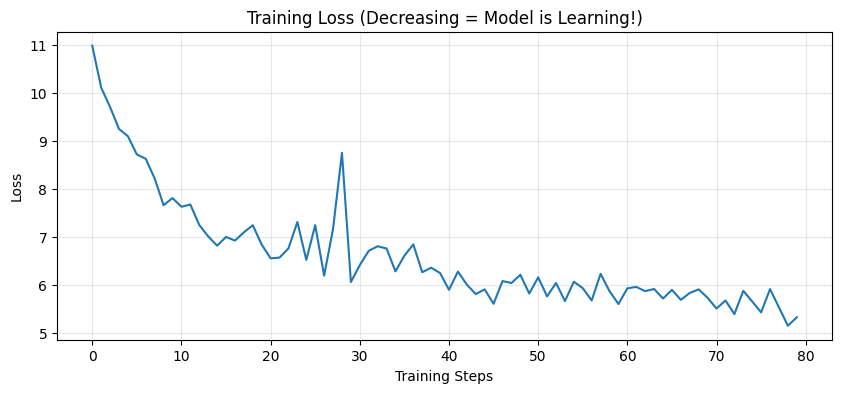

In [8]:
# Run mini training (this will take ~30 seconds)
print("Starting mini training demo...\n")
torch.manual_seed(42)
mini_model = GPTModel(GPT_CONFIG_124M)
mini_model.to(device)

losses = train_model_simple(mini_model, dataloader, num_epochs=2)

# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss (Decreasing = Model is Learning!)')
plt.grid(True, alpha=0.3)
plt.show()

---
# Part 2: Loading Pretrained Weights (30 min)
---

## 📢 Instructor Script
> "Training from scratch takes too long. Instead, let's load OpenAI's pretrained GPT-2 weights into our model!"

> "This is the magic moment - our model will actually generate coherent text!"

In [9]:
# We'll use a simplified weight loading approach
# In practice, you'd download from OpenAI or Hugging Face

def load_gpt2_weights_from_hf(model, model_name="gpt2"):
    """Load pretrained weights from Hugging Face."""
    try:
        from transformers import GPT2LMHeadModel
        
        print(f"Loading {model_name} from Hugging Face...")
        hf_model = GPT2LMHeadModel.from_pretrained(model_name)
        hf_dict = hf_model.state_dict()
        
        # Map Hugging Face keys to our model keys
        # This is a simplified version - real implementation needs careful mapping
        with torch.no_grad():
            # Token embeddings
            model.tok_emb.weight.copy_(hf_dict['transformer.wte.weight'])
            # Position embeddings
            model.pos_emb.weight.copy_(hf_dict['transformer.wpe.weight'])
            
            # Transformer blocks
            for i in range(len(model.trf_blocks)):
                # Attention weights
                qkv = hf_dict[f'transformer.h.{i}.attn.c_attn.weight']
                q, k, v = qkv.split(768, dim=1)
                model.trf_blocks[i].att.W_query.weight.copy_(q.T)
                model.trf_blocks[i].att.W_key.weight.copy_(k.T)
                model.trf_blocks[i].att.W_value.weight.copy_(v.T)
                model.trf_blocks[i].att.out_proj.weight.copy_(
                    hf_dict[f'transformer.h.{i}.attn.c_proj.weight'].T)
                model.trf_blocks[i].att.out_proj.bias.copy_(
                    hf_dict[f'transformer.h.{i}.attn.c_proj.bias'])
                # Attention biases
                qkv_b = hf_dict[f'transformer.h.{i}.attn.c_attn.bias']
                q_b, k_b, v_b = qkv_b.split(768)
                model.trf_blocks[i].att.W_query.bias.copy_(q_b)
                model.trf_blocks[i].att.W_key.bias.copy_(k_b)
                model.trf_blocks[i].att.W_value.bias.copy_(v_b)
                # FFN weights
                model.trf_blocks[i].ff.layers[0].weight.copy_(
                    hf_dict[f'transformer.h.{i}.mlp.c_fc.weight'].T)
                model.trf_blocks[i].ff.layers[0].bias.copy_(
                    hf_dict[f'transformer.h.{i}.mlp.c_fc.bias'])
                model.trf_blocks[i].ff.layers[2].weight.copy_(
                    hf_dict[f'transformer.h.{i}.mlp.c_proj.weight'].T)
                model.trf_blocks[i].ff.layers[2].bias.copy_(
                    hf_dict[f'transformer.h.{i}.mlp.c_proj.bias'])
                
                # LayerNorm
                model.trf_blocks[i].norm1.scale.copy_(hf_dict[f'transformer.h.{i}.ln_1.weight'])
                model.trf_blocks[i].norm1.shift.copy_(hf_dict[f'transformer.h.{i}.ln_1.bias'])
                model.trf_blocks[i].norm2.scale.copy_(hf_dict[f'transformer.h.{i}.ln_2.weight'])
                model.trf_blocks[i].norm2.shift.copy_(hf_dict[f'transformer.h.{i}.ln_2.bias'])
            
            # Final LayerNorm
            model.final_norm.scale.copy_(hf_dict['transformer.ln_f.weight'])
            model.final_norm.shift.copy_(hf_dict['transformer.ln_f.bias'])
            
            # Output head (weight tied with embeddings)
            model.out_head.weight.copy_(hf_dict['transformer.wte.weight'])
        
        print("✅ Weights loaded successfully!")
        return True
    except ImportError:
        print("❌ transformers library not installed. Run: pip install transformers")
        return False
    except Exception as e:
        print(f"❌ Error loading weights: {e}")
        return False

In [10]:
# Create model and load pretrained weights
GPT_CONFIG_124M["qkv_bias"] = True  # HF GPT-2 uses bias

model = GPTModel(GPT_CONFIG_124M)
success = load_gpt2_weights_from_hf(model, "gpt2")

if success:
    model.to(device)
    model.eval()
    print(f"\n🎉 Model ready for generation!")

c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading gpt2 from Hugging Face...
✅ Weights loaded successfully!

🎉 Model ready for generation!


## 🔮 Generate Real Text!

📢 **Say this:**
> "Now for the magic moment! Let's generate some real text!"

In [11]:
def generate_text(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=50):
    """Generate text with temperature and top-k sampling."""
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if temperature > 0:
            logits = logits / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [12]:
# Generate text!
if success:
    prompts = [
        "The future of artificial intelligence is",
        "Once upon a time, in a land far away,",
        "The secret to success in life is",
    ]
    
    print("Generated text with pretrained GPT-2:\n")
    print("=" * 60)
    
    for prompt in prompts:
        torch.manual_seed(42)
        input_ids = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)
        
        output = generate_text(
            model, input_ids,
            max_new_tokens=50,
            context_size=GPT_CONFIG_124M["context_length"],
            temperature=0.8,
            top_k=40
        )
        
        generated = tokenizer.decode(output[0].tolist())
        print(f"\n📝 {generated}")
        print("-" * 60)
else:
    print("⚠️ Pretrained weights not loaded. Install transformers: pip install transformers")

Generated text with pretrained GPT-2:


📝 The future of artificial intelligence is unknown."

"It's really difficult to say," said CTO of Microsoft's AI division, Mark Shuttleworth. A lot of the excitement for AI comes from the fact that it's possible to build machines from scratch.

In the
------------------------------------------------------------

📝 Once upon a time, in a land far away, there was no civilization, but the same things had happened. When I was young, I had never seen civilization before. When I was old, I knew there was no civilization, but I had never seen civilization before. When I was old, I
------------------------------------------------------------

📝 The secret to success in life is overcoming the fear that things will get really difficult.

The good news is that if you don't want to make the long journey, you can always take what is most important and offer it as a gift.

4) You can be
------------------------------------------------------------


📢 **Say this:**
> "Look at that! Our model from scratch, with pretrained weights, is generating coherent English! This is what billions of parameters trained on internet text can do!"

---
## ☕ BREAK (2:45 - 3:00)
---

---
# Part 3: Finetuning for Classification (60 min)
---

## 📢 Instructor Script
> "Pretrained models are great at general text, but what if we want them to do specific tasks? That's where **finetuning** comes in!"

> "We'll finetune GPT-2 to classify movie reviews as positive or negative."

## 🎯 Finetuning vs Pretraining

📢 **Say this:**

| Aspect | Pretraining | Finetuning |
|--------|-------------|------------|
| Goal | General language understanding | Specific task |
| Data | Billions of tokens | Thousands of examples |
| Time | Weeks | Minutes to hours |
| Learning rate | Higher | Much lower |

💡 **Types of Finetuning:**
1. **Classification**: Add classification head (what we'll do!)
2. **Instruction tuning**: Follow instructions (like ChatGPT)
3. **RLHF**: Align with human preferences

## 🔧 Modifying GPT for Classification

📢 **Say this:**
> "For classification, we replace the language modeling head with a classification head. We only look at the last token's representation."

```
text → GPT → [hidden states] → last token → Classification Head → Class
                                   ↑
                     Use last position as representation
```

In [13]:
class GPTClassifier(nn.Module):
    """GPT model modified for text classification."""
    
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.model = base_model
        emb_dim = base_model.out_head.in_features
        
        # Replace output head with classifier
        self.model.out_head = nn.Linear(emb_dim, num_classes)
    
    def forward(self, input_ids):
        # Get all hidden states
        x = self.model.tok_emb(input_ids)
        x = x + self.model.pos_emb(torch.arange(input_ids.shape[1], device=input_ids.device))
        x = self.model.drop_emb(x)
        x = self.model.trf_blocks(x)
        x = self.model.final_norm(x)
        
        # Use last token for classification
        last_hidden = x[:, -1, :]
        logits = self.model.out_head(last_hidden)
        return logits

## 📊 Create a Simple Classification Dataset

📢 **Say this:**
> "Let's create a simple spam detection dataset for demonstration."

In [14]:
# Simple spam dataset
spam_data = [
    ("Congratulations! You've won a free iPhone!", 1),
    ("Click here to claim your prize money now!", 1),
    ("URGENT: Your account has been compromised!", 1),
    ("You have been selected for a cash prize!", 1),
    ("Free money! No strings attached!", 1),
    ("Act now! Limited time offer!", 1),
    ("Winner! You've been chosen!", 1),
    ("Claim your free gift card today!", 1),
    ("Hey, can we meet for lunch tomorrow?", 0),
    ("The meeting has been rescheduled to 3pm.", 0),
    ("Please review the attached document.", 0),
    ("Thanks for your help with the project.", 0),
    ("I'll send you the report by end of day.", 0),
    ("Looking forward to our call next week.", 0),
    ("Great work on the presentation!", 0),
    ("Can you send me the updated file?", 0),
]

# More data for training
additional_spam = [
    ("EARN $$$ FROM HOME NOW!!!", 1),
    ("Your loan has been approved!", 1),
    ("Meeting notes from yesterday's call.", 0),
    ("Project deadline extended to Friday.", 0),
]

all_data = spam_data + additional_spam
print(f"Total samples: {len(all_data)}")
print(f"Spam: {sum(1 for _, label in all_data if label == 1)}")
print(f"Not spam: {sum(1 for _, label in all_data if label == 0)}")

Total samples: 20
Spam: 10
Not spam: 10


In [15]:
class SpamDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=64):
        self.texts = []
        self.labels = []
        
        for text, label in data:
            tokens = tokenizer.encode(text)
            # Pad or truncate to max_length
            if len(tokens) > max_length:
                tokens = tokens[:max_length]
            else:
                tokens = [tokenizer.encode(" ")[0]] * (max_length - len(tokens)) + tokens
            
            self.texts.append(torch.tensor(tokens))
            self.labels.append(label)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [16]:
# Split data
import random
random.seed(42)
random.shuffle(all_data)

train_data = all_data[:14]
test_data = all_data[14:]

train_dataset = SpamDataset(train_data, tokenizer)
test_dataset = SpamDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 14
Test samples: 6


## 🏋️ Finetuning the Classifier

In [17]:
def train_classifier(model, train_loader, test_loader, num_epochs=5, lr=1e-5):
    """Train classification model."""
    # Only optimize trainable parameters
    optimizer = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad], lr=lr
    )
    
    train_losses = []
    train_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_texts, batch_labels in train_loader:
            batch_texts = batch_texts.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            logits = model(batch_texts)
            loss = F.cross_entropy(logits, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_labels).sum().item()
            total += len(batch_labels)
        
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2%}")
    
    return train_losses, train_accs

In [18]:
# Create classifier from base model
if success:
    # Reload base model with fresh pretrained weights
    base_model = GPTModel(GPT_CONFIG_124M)
    load_gpt2_weights_from_hf(base_model, "gpt2")
    
    # Create classifier
    classifier = GPTClassifier(base_model, num_classes=2)
    classifier.to(device)
    
    # Freeze most layers (only train last layers + classifier head)
    for param in classifier.model.parameters():
        param.requires_grad = False
    
    # Unfreeze last transformer block and classifier head
    for param in classifier.model.trf_blocks[-1].parameters():
        param.requires_grad = True
    for param in classifier.model.out_head.parameters():
        param.requires_grad = True
    for param in classifier.model.final_norm.parameters():
        param.requires_grad = True
    
    
    # Keep frozen layers in eval mode to disable dropout
    classifier.eval()  # Set everything to eval
    # Then selectively set trainable parts to train mode
    classifier.model.trf_blocks[-1].train()
    classifier.model.out_head.train()
    classifier.model.final_norm.train()
    trainable = sum(p.numel() for p in classifier.parameters() if p.requires_grad)
    total = sum(p.numel() for p in classifier.parameters())
    print(f"\nTrainable parameters: {trainable:,} / {total:,} ({trainable/total:.1%})")

Loading gpt2 from Hugging Face...
✅ Weights loaded successfully!

Trainable parameters: 7,090,946 / 124,441,346 (5.7%)


In [19]:
# Train classifier
if success:
    print("\nTraining spam classifier...\n")
    losses, accs = train_classifier(classifier, train_loader, test_loader, num_epochs=20, lr=5e-4)


Training spam classifier...

Epoch 1/20 - Loss: 1.7144, Accuracy: 28.57%
Epoch 2/20 - Loss: 1.1536, Accuracy: 64.29%
Epoch 3/20 - Loss: 0.7607, Accuracy: 64.29%
Epoch 4/20 - Loss: 0.3373, Accuracy: 71.43%
Epoch 5/20 - Loss: 0.3367, Accuracy: 100.00%
Epoch 6/20 - Loss: 0.3268, Accuracy: 92.86%
Epoch 7/20 - Loss: 0.2033, Accuracy: 100.00%
Epoch 8/20 - Loss: 0.1047, Accuracy: 100.00%
Epoch 9/20 - Loss: 0.0514, Accuracy: 100.00%
Epoch 10/20 - Loss: 0.0286, Accuracy: 100.00%
Epoch 11/20 - Loss: 0.0174, Accuracy: 100.00%
Epoch 12/20 - Loss: 0.0126, Accuracy: 100.00%
Epoch 13/20 - Loss: 0.0049, Accuracy: 100.00%
Epoch 14/20 - Loss: 0.0024, Accuracy: 100.00%
Epoch 15/20 - Loss: 0.0036, Accuracy: 100.00%
Epoch 16/20 - Loss: 0.0011, Accuracy: 100.00%
Epoch 17/20 - Loss: 0.0011, Accuracy: 100.00%
Epoch 18/20 - Loss: 0.0029, Accuracy: 100.00%
Epoch 19/20 - Loss: 0.0029, Accuracy: 100.00%
Epoch 20/20 - Loss: 0.0013, Accuracy: 100.00%


In [20]:
# Evaluate on test set
if success:
    classifier.eval()
    correct = 0
    total = 0
    
    print("\nTest Set Predictions:")
    print("=" * 60)
    
    with torch.no_grad():
        for i, (text_ids, label) in enumerate(test_dataset):
            text_ids = text_ids.unsqueeze(0).to(device)
            logits = classifier(text_ids)
            pred = torch.argmax(logits, dim=1).item()
            
            text = tokenizer.decode(text_ids[0].tolist()).strip()
            status = "✅" if pred == label else "❌"
            label_str = "SPAM" if label == 1 else "OK"
            pred_str = "SPAM" if pred == 1 else "OK"
            
            print(f"{status} True: {label_str:4} | Pred: {pred_str:4} | '{text[:40]}...'")
            
            correct += (pred == label)
            total += 1
    
    print(f"\n📊 Test Accuracy: {correct/total:.2%}")


Test Set Predictions:
✅ True: SPAM | Pred: SPAM | 'URGENT: Your account has been compromise...'
✅ True: SPAM | Pred: SPAM | 'EARN $$$ FROM HOME NOW!!!...'
✅ True: SPAM | Pred: SPAM | 'Claim your free gift card today!...'
✅ True: OK   | Pred: OK   | 'Hey, can we meet for lunch tomorrow?...'
✅ True: SPAM | Pred: SPAM | 'Congratulations! You've won a free iPhon...'
✅ True: SPAM | Pred: SPAM | 'You have been selected for a cash prize!...'

📊 Test Accuracy: 100.00%


## 🧪 Try Your Own Messages!

In [23]:
def classify_text(text, classifier, tokenizer, max_length=64):
    """Classify a single text."""
    classifier.eval()
    tokens = tokenizer.encode(text)
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    else:
        tokens = [tokenizer.encode(" ")[0]] * (max_length - len(tokens)) + tokens
    
    with torch.no_grad():
        input_ids = torch.tensor(tokens).unsqueeze(0).to(device)
        logits = classifier(input_ids)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1).item()
    
    return "SPAM 🚨" if pred == 1 else "OK ✅", probs[0].tolist()

In [24]:
# Test with new messages
if success:
    test_messages = [
        "You've won $1,000,000! Claim now!",
        "Can you send me the meeting notes?",
        "URGENT: Password reset required immediately!",
        "Thanks for the help yesterday, really appreciated it.",
    ]
    
    print("🔍 Spam Detection Results:\n")
    for msg in test_messages:
        result, probs = classify_text(msg, classifier, tokenizer)
        print(f"{result} (conf: {max(probs):.2%}): '{msg}'")

🔍 Spam Detection Results:

SPAM 🚨 (conf: 100.00%): 'You've won $1,000,000! Claim now!'
OK ✅ (conf: 99.94%): 'Can you send me the meeting notes?'
SPAM 🚨 (conf: 99.13%): 'URGENT: Password reset required immediately!'
OK ✅ (conf: 99.93%): 'Thanks for the help yesterday, really appreciated it.'


---
# Part 4: Workshop Wrap-up (30 min)
---

## 📢 Instructor Script

> "Congratulations everyone! You've just built a Large Language Model from SCRATCH!"

## 📝 What We Accomplished

### Day 1
- ✅ **Session 1**: Tokenization, embeddings, data loading
- ✅ **Session 2**: Self-attention, multi-head attention

### Day 2  
- ✅ **Session 3**: Complete GPT architecture, text generation
- ✅ **Session 4**: Pretraining, loading weights, finetuning

### You Now Understand:
1. How text becomes numbers (tokenization)
2. How attention lets tokens "see" each other
3. How GPT generates text (next-token prediction)
4. How to adapt LLMs for specific tasks (finetuning)

## 🚀 What's Next?

📢 **Say this:**
> "Your LLM journey doesn't end here! Here's what you can explore next:"

### Immediate Next Steps:
1. **Run the full notebooks** from [LLMs-from-scratch](https://github.com/rasbt/LLMs-from-scratch)
2. **Read the book**: "Build a Large Language Model From Scratch"
3. **Watch the 17-hour video course** companion

### Advanced Topics:
1. **Instruction Tuning** (Chapter 7) - Make models follow instructions
2. **LoRA** (Appendix E) - Efficient finetuning with fewer parameters
3. **DPO/RLHF** - Align models with human preferences
4. **Llama, Mistral, Qwen** - Build other architectures

### Resources:
- 📖 [LLMs from Scratch Book](https://www.manning.com/books/build-a-large-language-model-from-scratch)
- 💻 [GitHub Repository](https://github.com/rasbt/LLMs-from-scratch)
- 🎥 [Video Course](https://www.manning.com/livevideo/master-and-build-large-language-models)
- 📚 [Reasoning From Scratch (sequel)](https://github.com/rasbt/reasoning-from-scratch)

## 🙋 Q&A Time

📢 **Open floor for questions!**

---
## 🎉 Thank You!

```
   _____ ____  _   _  _____ _____       _______ _____ _ 
  / ____/ __ \| \ | |/ ____|  __ \     /\|__   __/ ____| |
 | |   | |  | |  \| | |  __| |__) |   /  \  | | | (___ | |
 | |   | |  | | . ` | | |_ |  _  /   / /\ \ | |  \___ \| |
 | |___| |__| | |\  | |__| | | \ \  / ____ \| |  ____) |_|
  \_____\____/|_| \_|\_____|_|  \_\/_/    \_\_| |_____/(_)
```

You've completed the **Build an LLM From Scratch** workshop!

🌟 **Keep building, keep learning!** 🌟